# Homework 6

# Задача №1 - Выделить береговую линию

Теперь приступим к задаче сегментации на картинках. Реализуйте программу, которая определить береговую линию, то есть разделит изображение на 2 класса: берег и вода. 

Примеры изображений:
<table><tr>
    <td> <img src="ships/0d5b831d8.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="ships/8bb60a003.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="ships/161dfbbdc.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

### Короткое описание подхода
Для решения задачи я принял решение провести несколько кластеризаций. Сначала усредняя локальные характеристики по средству super pixels. Затем объединение этих пикселей в два кластера аггломеративным алгоритмом. 

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.cluster import AgglomerativeClustering
from skimage.color import label2rgb
from sklearn.feature_extraction.image import grid_to_graph
from skimage.segmentation import slic

In [2]:
def preproc(image: cv2.Mat) -> cv2.Mat:
    """
    Image preprocessing
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))
    return image

In [3]:
def plot_result(image: cv2.Mat, label: cv2.Mat, n_clusters: int) -> None:
    """
    Plot clusters borders 
    """
    cmap = plt.cm.get_cmap('Spectral', n_clusters)
    rgba = cmap(np.linspace(0, 1, n_clusters))

    plt.imshow(image, cmap=plt.cm.gray)
    for l in range(n_clusters):
        tmp = label == l
        if len(tmp.shape) == 3:
            plt.contour(tmp[:, :, 0], colors=[rgba[l]])
        else:
            plt.contour(tmp[:, :], colors=[rgba[l]])
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [4]:
def slic_preprocessing(image: cv2.Mat) -> cv2.Mat:
    """
    Segments image using k-means clustering in Color-(x,y,z) space.
    """
    segments = slic(
        image,
        sigma=2,
        channel_axis=2,
        n_segments=50,
        compactness=20
    )

    segmented = label2rgb(
        segments,
        image,
        kind='avg',
        channel_axis=2
    )
    return segmented

In [5]:
def agglomeration(image: cv2.Mat) -> cv2.Mat:
    """
    Recursively merges pair of clusters of sample data
    """
    X = np.reshape(image, (-1, 1))
    connectivity = grid_to_graph(*image.shape)

    ward = AgglomerativeClustering(
        n_clusters=2,
        linkage='ward',
        connectivity=connectivity
    ).fit(X)
    
    label = np.reshape(ward.labels_, image.shape)
    return label

In [6]:
def segmentation(image: cv2.Mat) -> None:
    """
    Segmentation pipeline
    """
    plt.figure(figsize=(5.4*4, 4.8), constrained_layout=False)
    
    plt.subplot(1, 4, 1)
    plt.title("Original")
    plt.axis("off")
    plt.imshow(image)
    
    slic = slic_preprocessing(image)
    plt.subplot(1, 4, 2)
    plt.title("Super pixels")
    plt.axis("off")
    plt.imshow(slic)
    
    agglom = agglomeration(slic)
    plt.subplot(1, 4, 3)
    plt.title("Agglomirated")
    plt.axis("off")
    plt.imshow(agglom * 255)
    
    plt.subplot(1, 4, 4)
    plt.title("Borders")
    plot_result(image, agglom, 2)

In [7]:
images = []

for i, img in enumerate(os.listdir("ships/")):
    images += [preproc(cv2.imread("ships/"+img))]

images = np.array(images)

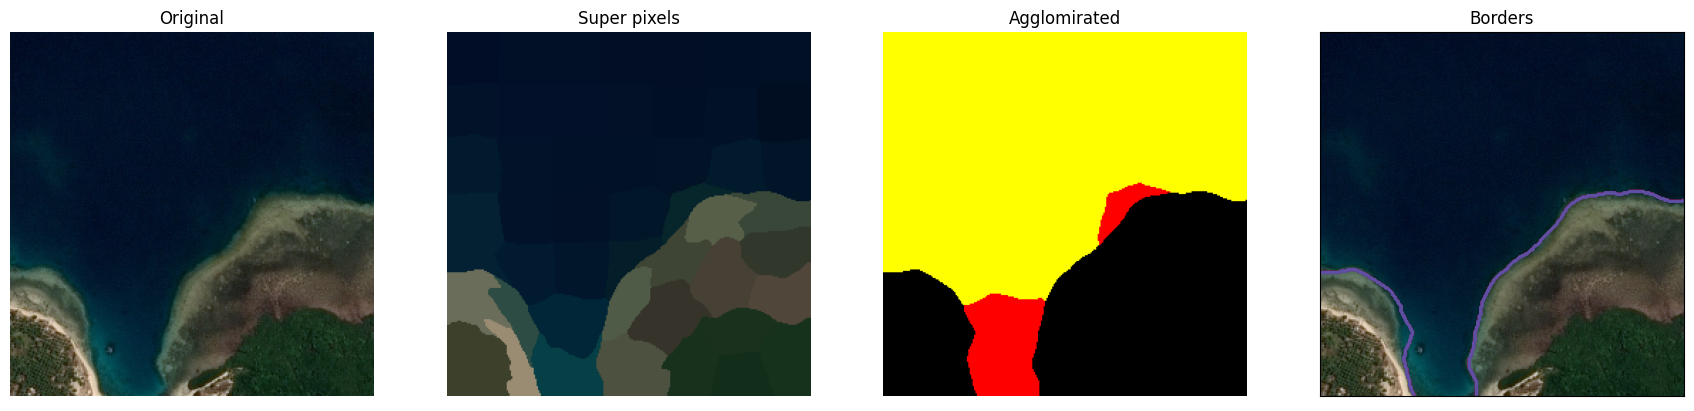

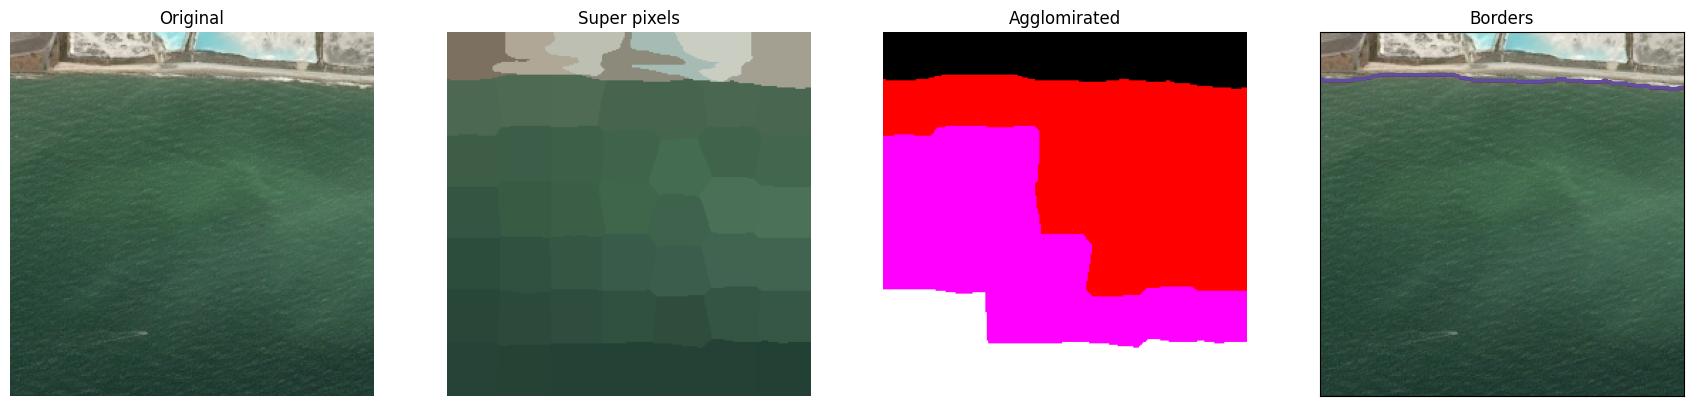

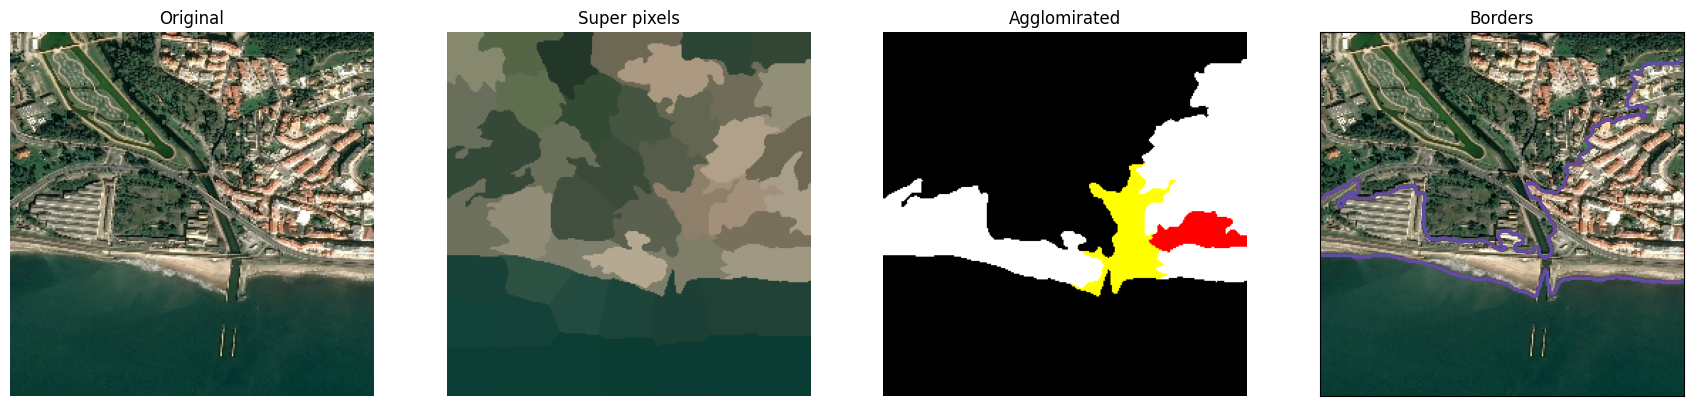

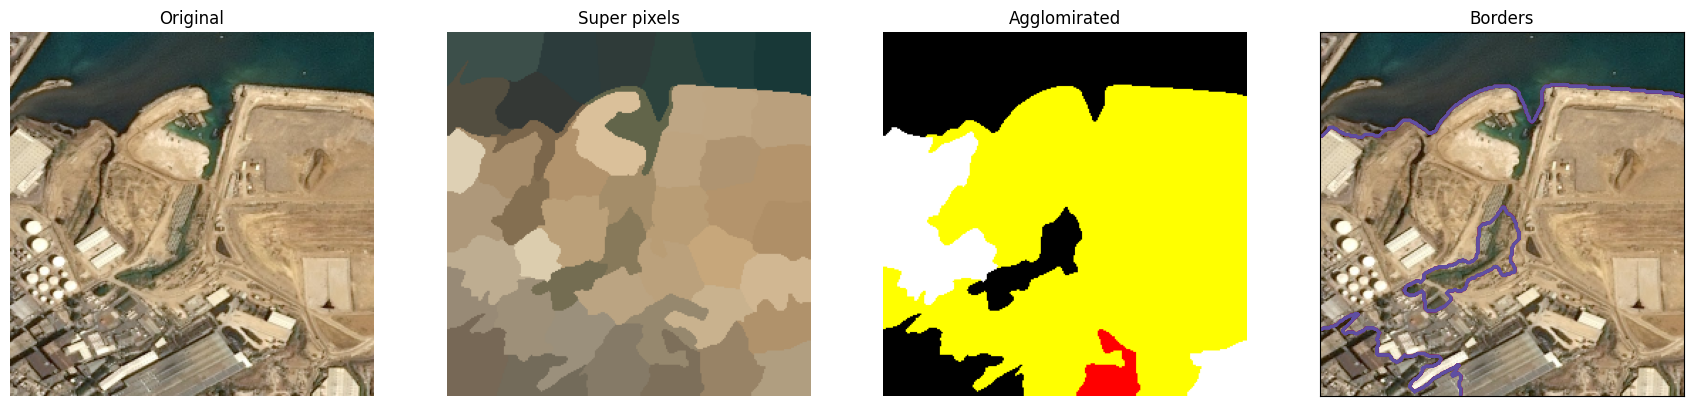

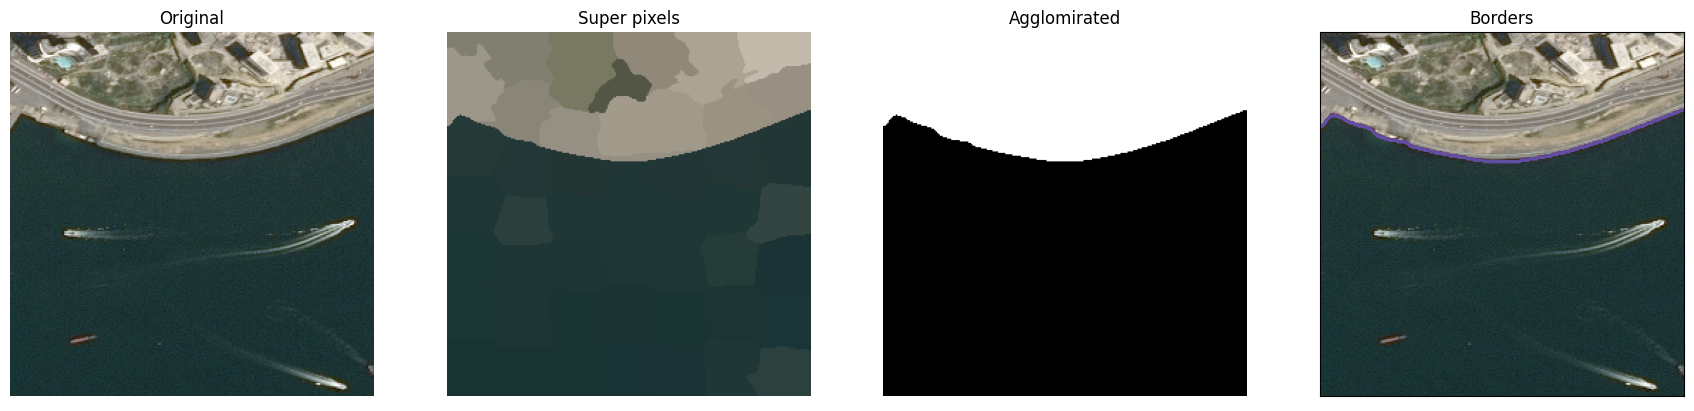

In [8]:
num_images = 5
rnd_idx = np.random.choice(len(images), size=num_images, replace=False)
samples = images[rnd_idx]

for image in samples:
    segmentation(image)